In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import json
import datetime


file_name = "./Data/all_labeled_images_data.h5"

base_dir = "./"+file_name

with open("./Our_images/Capstone/our_images_labaled_data.json", "r") as outfile:
    pointcloud_data = json.load(outfile)

classes = ['LookLeft', 'LookRight', 'LookUp', 'Neutral', 'RaiseEyebrows', 'Smile', 'OpenMouth']


In [2]:
#split data into training and validation if neccessary
SPLIT_RATIO = 0.7
with h5py.File(file_name, "r") as file:
    c = list(zip(list(file['images']),list(file['labels'])))
    sz = len(c)
    cut_training = int(sz*SPLIT_RATIO)
    cut_test_val = int(((sz-cut_training)*0.5) + cut_training)
    random.shuffle(c)
    
#     print("sz:" + str(sz))
#     print("cut_test_val:" + str(cut_test_val))
    training=c[:cut_training]
    testing=c[cut_training:cut_test_val]
    validation = c[cut_test_val:]
    
    training_data=[]
    training_labels=[]
    testing_data=[]
    testing_labels=[]
    validation_data=[]
    validation_labels=[]
    
    for a in training:
        training_data.append(a[0])
        training_labels.append(a[1])

    for a in testing:
        testing_data.append(a[0])
        testing_labels.append(a[1])

    for a in validation:
        validation_data.append(a[0])
        validation_labels.append(a[1])

training_x=np.array(training_data)
training_labels=np.array(training_labels)
training_data = tf.data.Dataset.from_tensor_slices((training_x, training_labels))
testing_x=np.array(testing_data)
testing_labels=np.array(testing_labels)
testing_data = tf.data.Dataset.from_tensor_slices((testing_x, testing_labels))
val_x=np.array(validation_data)
val_labels=np.array(validation_labels)
val_data = tf.data.Dataset.from_tensor_slices((val_x, val_labels))
display(training_data, testing_data, val_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(255, 255, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

<TensorSliceDataset element_spec=(TensorSpec(shape=(255, 255, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

<TensorSliceDataset element_spec=(TensorSpec(shape=(255, 255, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [3]:
# import time
# class ArtificialDataset(tf.data.Dataset):
#     def _generator(num_samples):
#         # Opening the file
#         time.sleep(0.03)

#         for sample_idx in range(num_samples):
#             # Reading data (line, record) from the file
#             time.sleep(0.015)

#             yield (sample_idx,)

#     def __new__(cls, num_samples=3):
#         return tf.data.Dataset.from_generator(
#             cls._generator,
#             output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
#             args=(num_samples,)
#         )

In [4]:
# def benchmark(dataset, num_epochs=2):
#     start_time = time.perf_counter()
#     for epoch_num in range(num_epochs):
#         for sample in dataset:
#             # Performing a training step
#             time.sleep(0.01)
#     print("Execution time:", time.perf_counter() - start_time)


In [5]:
# benchmark(
#     ArtificialDataset()
#     .prefetch(tf.data.AUTOTUNE)
# )


In [20]:

IMAGE_SIZE = 255

BATCH_SIZE = 32

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# train_dataset = training_data.range(100)
# train_dataset = training_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
# display(input_shape)



data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.8),
    layers.RandomContrast(0.8),
    layers.RandomRotation(0.6)
])

aug_ds = training_data.map(
  lambda x, y: (data_augmentation(x, training=True), y))
test_ds = testing_data.map(
  lambda x, y: (data_augmentation(x, training=True), y))

aug_ds = aug_ds.cache().shuffle(3000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

aug_ds = aug_ds.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).repeat()
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)

# for image_batch, labels_batch in aug_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

inputs = keras.Input(shape=input_shape)
num_classes = len(classes)


x = layers.Rescaling(1.0 / IMAGE_SIZE)(inputs)  # Rescale inputs


base_model = keras.applications.ResNet50V2(  # Add the rest of the model
    weights=None, input_shape=input_shape, classes=num_classes, pooling="avg"
)(x)

dropout = tf.keras.layers.Dropout(0.15)
base_model = dropout(base_model)
model_name = "RESNET50V2_our_data_contrast_brightness_avg_pooling_0_03"

model = keras.Model(inputs, base_model, name=model_name)

model.compile(optimizer=keras.optimizers.experimental.RMSprop(learning_rate=0.05), 
                loss="sparse_categorical_crossentropy", 
                metrics=[keras.metrics.SparseCategoricalAccuracy()])

# data_generator.fit(training_data)

# display(training_data.shape)
# display(training_labels.shape)

# for image_batch, label_batch in train_generator:
#     break

In [21]:
try:
    model.load_weights("./checkpoint_/best_"+ model_name)
except:
    print("no weights")

In [19]:
logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
checkpoint_filepath = "./checkpoint_/best_"+model_name

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

def scheduler(epoch, lr):
    if epoch < 60:
        return lr
    else:
#         print("learning rate: " + lr)
        return lr * tf.math.exp(-0.1)

learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

history = model.fit(aug_ds, 
                    epochs=500,
                    batch_size=BATCH_SIZE,
                    validation_data=test_ds,
                    callbacks=[model_checkpoint_callback,tensorboard_callback, early_stopping_callback, learning_rate_callback], 
                    steps_per_epoch=30,
                    shuffle=True,
#                     initial_epoch=58,
#                     validation_steps=10,
                    validation_batch_size=BATCH_SIZE,
                    workers=10,
                    use_multiprocessing=True
                    )


Epoch 1/500
30/30 [==============================] - 53s 753ms/step - loss: 12.3286 - sparse_categorical_accuracy: 0.1312 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 2/500
30/30 [==============================] - 10s 346ms/step - loss: 11.8293 - sparse_categorical_accuracy: 0.1437 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 3/500
30/30 [==============================] - 11s 362ms/step - loss: 12.0319 - sparse_categorical_accuracy: 0.1458 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 4/500
30/30 [==============================] - 11s 371ms/step - loss: 11.8513 - sparse_categorical_accuracy: 0.1552 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 5/500
30/30 [==============================] - 9s 312ms/step - loss: 12.0583 - sparse_categorical_accuracy: 0.1333 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 6/500
30/3

Epoch 43/500
30/30 [==============================] - 9s 291ms/step - loss: 12.3032 - sparse_categorical_accuracy: 0.1375 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 44/500
30/30 [==============================] - 9s 294ms/step - loss: 11.9936 - sparse_categorical_accuracy: 0.1462 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 45/500
30/30 [==============================] - 9s 294ms/step - loss: 12.0950 - sparse_categorical_accuracy: 0.1469 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 46/500
30/30 [==============================] - 9s 301ms/step - loss: 12.1871 - sparse_categorical_accuracy: 0.1344 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 47/500
30/30 [==============================] - 9s 291ms/step - loss: 12.1353 - sparse_categorical_accuracy: 0.1344 - val_loss: 13.7967 - val_sparse_categorical_accuracy: 0.1440 - lr: 0.0061
Epoch 48/500
30

KeyboardInterrupt: 

In [13]:
model.save_weights("./weights/last_"+ model_name)

In [ ]:
#save weights as .json for react
# weights = model.get_weights()

# weights_json = [w.tolist() for w in weights]

# with open("jsmodelweights.json", "w") as outfile:
#     json.dump(weights_json, outfile)


In [13]:
#save best validation accuracy model
try:
    model.load_weights("./checkpoint_/best_"+ model_name)
except:
    print("no weights")
model_filepath = "./model/best_"+model_name
model.save(model_filepath)

INFO:tensorflow:Assets written to: ./model/best_RESNET50V2_our_data_contrast_brightness_avg_pooling_0_03\assets


INFO:tensorflow:Assets written to: ./model/best_RESNET50V2_our_data_contrast_brightness_avg_pooling_0_03\assets


In [8]:
#save last model weights
try:
    model.load_weights("./weights/last_"+ model_name)
except:
    print("no weights")
model_filepath = "./model/last_"+model_name
model.save(model_filepath)

INFO:tensorflow:Assets written to: ./model/last_RESNET50V2_our_data_full_augment_avg_pooling_e-2\assets


INFO:tensorflow:Assets written to: ./model/last_RESNET50V2_our_data_full_augment_avg_pooling_e-2\assets


In [22]:
# model.load_weights("./checkpoint_/best_"+ model_name)
val_ds = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)

results = model.evaluate(val_ds, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

70/70 [==============================] - 4s 44ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9982
test loss, test acc: [0.009475363418459892, 0.9981892108917236]


1/1 [==============================] - 0s 21ms/step
classes:
['LookLeft', 'LookRight', 'LookUp', 'Neutral', 'RaiseEyebrows', 'Smile', 'OpenMouth']
predictions shape: (1, 7)
predictions: [[3.8117861e-35 3.8740390e-15 1.0000000e+00 9.8998404e-30 5.6313903e-28
  0.0000000e+00 1.6264857e-26]]
actual: [2]
prediction: LookUp
actual: LookUp


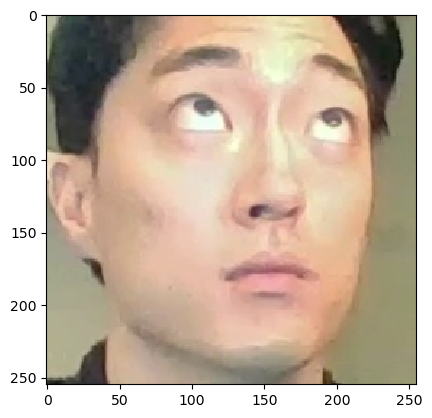

In [26]:
index_start = 1
index_end = index_start+1
predictions = model.predict(testing_x[index_start:index_end])
print("classes:")
print(classes)
print("predictions shape:", predictions.shape)
print("predictions:", predictions)
print("actual:", testing_labels[index_start:index_end])
predClassID = np.argmax(predictions)
predClassName = classes[predClassID]
print("prediction:", predClassName)
actClassID = testing_labels[index_start:index_end][0]
actClassName = classes[actClassID]
print("actual:", actClassName)
plt.imshow(testing_x[index_start], interpolation='nearest')
plt.show()

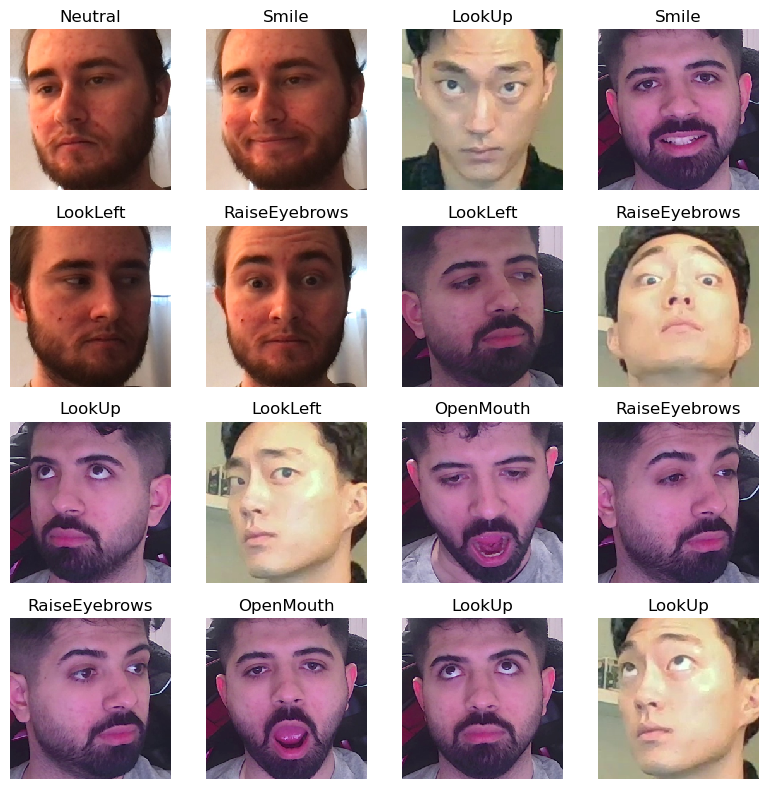

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(validation_data[i], interpolation='nearest')
    ax.set_axis_off()
    ax.set_title(classes[val_labels[i]])
plt.tight_layout()
plt.show()

70/70 [==============================] - 3s 36ms/step


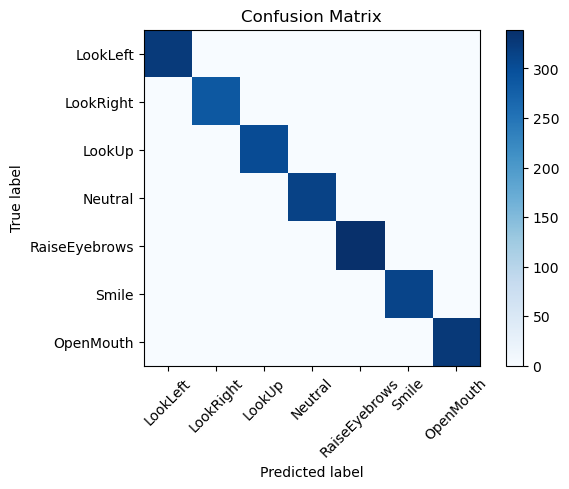

In [31]:
y_pred = model.predict(val_ds)

confusion_mtx = tf.math.confusion_matrix(val_labels, y_pred.argmax(axis=1))

# Convert the confusion matrix to a NumPy array
confusion_mtx = confusion_mtx.numpy()

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

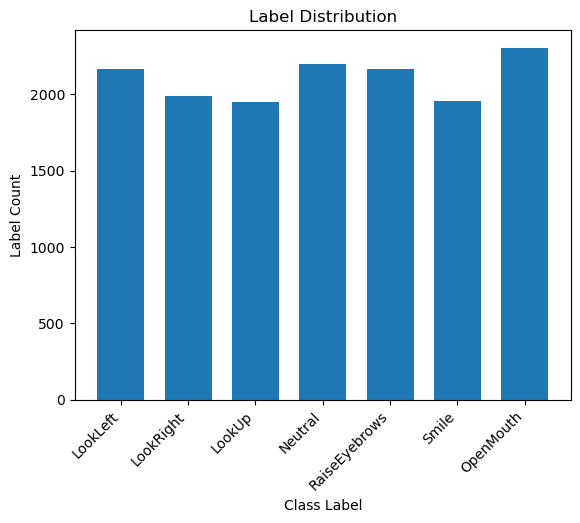

In [45]:
labels = np.concatenate((training_labels, testing_labels, validation_labels))
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plot the label distribution as a bar chart
plt.bar(classes, label_counts, width=0.7)
plt.xlabel('Class Label')
plt.ylabel('Label Count')
plt.title('Label Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()